In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


# 1. Create spark session

In [2]:
# Note: This may take some time on first startup to install all the dependencies
catalog_key = "resultcatalog"
spark = SparkSession.builder \
    .appName("GBTClassifierExample") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1") \
    .config('spark.cassandra.connection.host', 'cassandra') \
    .config('spark.cassandra.connection.port', '9042') \
    .config('spark.cassandra.output.consistency.level','ONE') \
    .config(f'spark.sql.catalog.{catalog_key}', 'com.datastax.spark.connector.datasource.CassandraCatalog') \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

# 2. Load data

In [3]:
local_path = "../data/Base.csv"
hdfs_path = "hdfs://namenode:8020/data/Base.parquet"

try:
    df = spark.read.parquet(hdfs_path)
    print("Data already in HDFS")
except:
    print("Data not in HDFS → Storing data in HDFS")
    tmp_df = spark.read.csv(local_path, header=True, inferSchema=True)
    tmp_df.write.parquet(hdfs_path)
    df = spark.read.parquet(hdfs_path)

Data already in HDFS


# 3. Remove not needed features
From EDA we saw that we should remove: 'device_fraud_count'

In [4]:
df = df.drop("device_fraud_count")

# 3. Address class imbalance

In [5]:
# calculate the class distribution
fraud_count = df.filter(df.fraud_bool == 1).count()
no_fraud_count = df.filter(df.fraud_bool == 0).count()

total_count = fraud_count + no_fraud_count
fraud_weight = total_count / (2.0 * fraud_count)  # minority class (fraud)
legit_weight = total_count / (2.0 * no_fraud_count)  # majority class (legit)

# create a weight column
df = df.withColumn("class_weight", F.when(df.fraud_bool == 1, fraud_weight).otherwise(legit_weight))


# 4. One-hot encoding
From EDA we already know which features are cat and which ones are num. Now, from the cat, we will only one-hot encode the ones that are not binary. These are: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [6]:
cat_features = ['payment_type',
'employment_status',
'housing_status',
'source',
'device_os',
'keep_alive_session',
'foreign_request',
'has_other_cards',
'phone_mobile_valid',
'phone_home_valid',
'email_is_free',
'customer_age']

one_hot_features = ['payment_type', 
'employment_status', 
'housing_status', 
'source', 
'device_os']

num_features = ['income',
'name_email_similarity',
'prev_address_months_count',
'current_address_months_count',
'days_since_request',
'intended_balcon_amount',
'zip_count_4w',
'velocity_6h',
'velocity_24h',
'velocity_4w',
'bank_branch_count_8w',
'date_of_birth_distinct_emails_4w',
'credit_risk_score',
'bank_months_count',
'proposed_credit_limit',
'session_length_in_minutes',
'device_distinct_emails_8w',
'month']

In [7]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in one_hot_features]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in one_hot_features]
encoded_cols = [col + "_encoded" for col in one_hot_features]

# assemble all the features into a single feature vector
assembler = VectorAssembler(inputCols=num_features + encoded_cols, outputCol="features")


# 4. Training
Define model, split data, create pipeline and fit the model. 

In [8]:
gbt = GBTClassifier(labelCol="fraud_bool", weightCol="class_weight", featuresCol="features", maxIter=10)
train_df, test_df = df.randomSplit([0.9, 0.1], seed=42) # same split and seed as in EDA 
pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])
gbt_model = pipeline.fit(train_df)

# 5. Evaluation

In [9]:
predictions = gbt_model.transform(test_df)

## 5.1. AUC


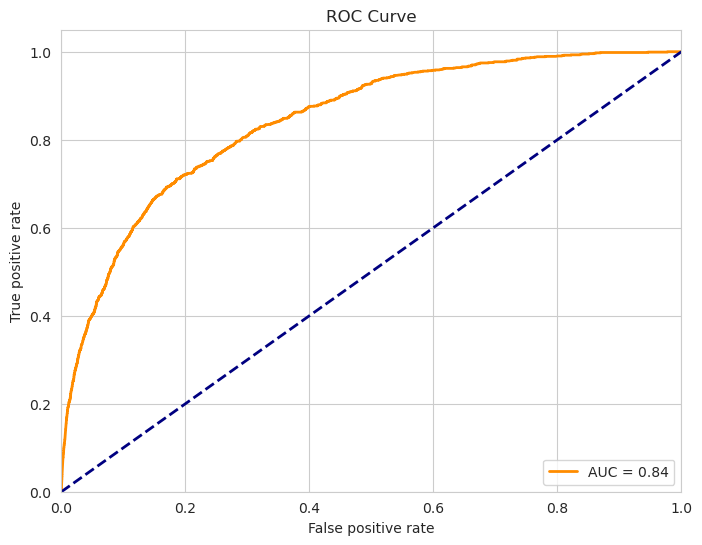

In [10]:
# extract true labels and predicted probabilities
predictions_pd = predictions.select("fraud_bool", "probability").toPandas()
predictions_pd["probability_class_1"] = predictions_pd["probability"].apply(lambda x: x[1])

# compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(predictions_pd["fraud_bool"], predictions_pd["probability_class_1"])
roc_auc = auc(fpr, tpr)

# plot 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 5.2. Precision, Recall and F1

In [11]:
# BinaryClassificationEvaluator only suppors AUC and PR, so to calculate these other metrics, need to do it as follows:

precision_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_bool", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9961715950398309
Recall: 0.7801827267679572
F1-Score: 0.8659255445386216


## 5.3. Confusion matrix

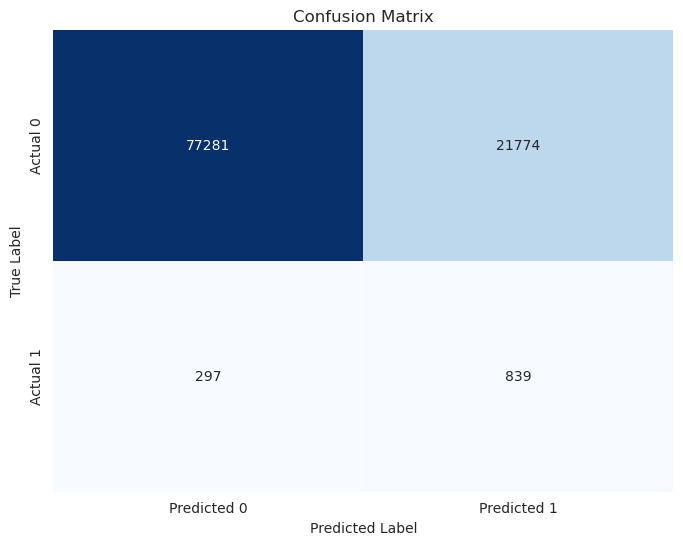

In [12]:
confusion_matrix = predictions.groupBy("fraud_bool", "prediction").count()
confusion_matrix_pd = confusion_matrix.toPandas()
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='fraud_bool', columns='prediction', values='count').fillna(0) # create the 2D matrix required by Seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 5.4. Example of predictions

In [13]:
predictions.select("fraud_bool", "prediction", "probability").show(10, truncate=False)


+----------+----------+----------------------------------------+
|fraud_bool|prediction|probability                             |
+----------+----------+----------------------------------------+
|0         |0.0       |[0.7772506041827985,0.22274939581720155]|
|0         |1.0       |[0.44058941327551415,0.5594105867244858]|
|0         |1.0       |[0.21597712685805992,0.7840228731419401]|
|0         |1.0       |[0.45706014503535974,0.5429398549646403]|
|0         |0.0       |[0.802741131585529,0.19725886841447104] |
|0         |0.0       |[0.8529083752963174,0.14709162470368264]|
|0         |0.0       |[0.713553890049571,0.28644610995042896] |
|0         |0.0       |[0.8091129695285191,0.19088703047148092]|
|0         |0.0       |[0.9011170145320033,0.09888298546799668]|
|0         |1.0       |[0.3426387647911777,0.6573612352088223] |
+----------+----------+----------------------------------------+
only showing top 10 rows



# 6. Save results


## 6.1. Prepare keyspace and table

In [15]:
# NOTE: sample_id is not traceable to the original data. In real scenario, should introduce it earlier and save it in the original data.
result_view = predictions.withColumn("sample_id", F.monotonically_increasing_id()) 
result_view = result_view.select("sample_id", "fraud_bool", "prediction")
# Extract schema from DataFrame
schema = result_view.schema

# Set up the keyspace and table
KEYSPACE = "results"
TABLE = "gbt_basic"

# Create column definitions
columns = []
for field in schema:
    if field.dataType.simpleString() == "vector":
        columns.append(f"{field.name} frozen<list<double>>")  # Handling the 'vector' type as 'list<double>'
    else:
        columns.append(f"{field.name} {field.dataType.simpleString()}")

columns_str = ", ".join(columns)

# Set up the keyspace and table
create_keyspace_sql = f"CREATE DATABASE IF NOT EXISTS {catalog_key}.{KEYSPACE} WITH DBPROPERTIES (class='SimpleStrategy', replication_factor='1')"
spark.sql(create_keyspace_sql)

# Define table creation query with PRIMARY KEY and PARTITIONED BY
create_table_sql = f"""
CREATE TABLE IF NOT EXISTS {catalog_key}.{KEYSPACE}.{TABLE} (
    {columns_str}
) PARTITIONED BY (sample_id)
"""
# Execute the query
spark.sql(create_table_sql)

DataFrame[]

## 6.2. Write results to table

In [16]:
# NOTE: Truncate and overwrite settings are only for testing purposes and would not be appropriate in production
result_view.write.format("org.apache.spark.sql.cassandra")\
    .options(table=TABLE, keyspace=KEYSPACE)\
    .option("confirm.truncate","true")\
    .mode("overwrite")\
    .save()